In [1]:
# libs
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.distributions.normal import Normal
import torch.nn.functional as F
import torch.utils.data as Data
from torch import nn
from torch import optim
from torch.autograd import Variable
# torch.manual_seed(42)
import torch.utils.data
from torchvision import datasets, transforms
import struct
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

---
* Utilities

In [3]:
def plots_dataset(X_tc):
    plt.figure(figsize=(20,7))
    plt.subplot(131)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,1],'bo')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.subplot(132)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,2],'bo')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 3")
    plt.subplot(133)
    plt.plot(X_tc.data.numpy()[:,1],X_tc.data.numpy()[:,2],'bo')
    plt.xlabel("Feature 2")
    plt.ylabel("Feature 3")
    plt.savefig('images/gan-4',quality=100)
    plt.show()

def plots_dims(X_tc,G_sample_plot):
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,1],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,0],G_sample_plot.data.numpy()[:,1],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.subplot(132)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,2],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,0],G_sample_plot.data.numpy()[:,2],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 3")
    plt.subplot(133)
    plt.plot(X_tc.data.numpy()[:,1],X_tc.data.numpy()[:,2],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,1],G_sample_plot.data.numpy()[:,2],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 2")
    plt.ylabel("Feature 3")
    plt.savefig('images/real_e_falso',quality=100)
    plt.show()

def plot_losses(losses_his):
    plt.figure(figsize=(20,8))
    plt.subplot(221)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(222)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(223)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Real')
    plt.subplot(224)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Falso')
    plt.savefig('images/losses_plot',quality=100)
    plt.show()

def plot_digit(x):
    x = x.data.numpy().reshape(data1.shape[1],data1.shape[2])
    plt.imshow(x,cmap='gray_r')
    plt.show()
    
def generate_samples(encoder,decoder,mb_size):
    for _, batch in enumerate(loader):
        X = Variable(batch[0]).to(device)
        X_size = X.shape[0]
        X = X.reshape(X_size,28*28).to(device)
#         y = Variable(batch[1]).to(device)
        z = Variable(torch.randn(X_size, Z_dim)).to(device)
        z_mu, z_var = encoder(X)
        z = sample_z(z_mu, z_var,X_size)
        X_sample = decoder(z)
    return X_sample[:mb_size]

def plot_n_random_digits(x,labels=None,n_images=9,title='Digits'):
    """Ate 20 imagens"""
    indices = np.random.choice(x.shape[0],size=n_images)
    x = x[indices].data.numpy()
    if isinstance(labels, torch.IntTensor):
        sample_labels = labels[indices].data.numpy()
    else: sample_labels = ['None']*len(indices)
    x = x.reshape(n_images,data1.shape[1],data1.shape[2])
    plt.clf()
    plt.style.use('seaborn-muted')
    fig, axes = plt.subplots(2,10, figsize=(15,3), sharex=True, sharey=True,
                             subplot_kw=dict(adjustable='box', aspect='equal'))
    for i in range(n_images):
        subplot_row = i//10
        subplot_col = i%10  
        ax = axes[subplot_row, subplot_col]
        plottable_image = x[i,:]
        ax.imshow(plottable_image, cmap='gray_r')
        ax.set_title('Digit Label: {}'.format(sample_labels[i]))
        ax.set_xbound([0,28])
    plt.tight_layout()
    plt.show()

def print_label(label):
    chosen_label = label
    batch = 1000
    y_sample = np.zeros(shape=[batch, y_dim])
    y_sample[:,chosen_label] = 1
    y_sample_tc = torch.Tensor(y_sample).type(torch.IntTensor)
    plot_n_random_digits(G(Variable(torch.randn(batch, Z_dim)).cuda(),
                         y_sample_tc.type(torch.FloatTensor).cuda()).cpu(),
                         labels=torch.max(y_sample_tc,dim=1)[1].type(torch.IntTensor),
                         n_images=20,title='conditional_gan_generated_{}_{}_'.format(chosen_label,epochs))

In [4]:
file_images = '/home/ninja/MNIST/train-images.idx3-ubyte'
file_labels = '/home/ninja/MNIST/train-labels.idx1-ubyte'

In [5]:
with open(file_images,'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data1 = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data1 = data1.reshape((size, nrows, ncols))

data1.shape

(60000, 28, 28)

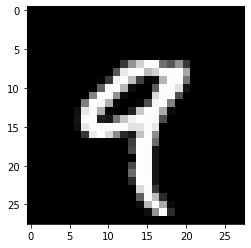

In [6]:
plt.imshow(data1[4,:,:], cmap='gray')
plt.show()

In [7]:
data = data1.reshape(data1.shape[0],data1.shape[1]*data1.shape[2])
data.shape

(60000, 784)

In [8]:
with open(file_labels,'rb') as f:
    labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))

labels = labels[8:]
labels.shape

(60000,)

---

In [9]:
data = MinMaxScaler().fit_transform(data)

X_tc = torch.Tensor(data).type(torch.FloatTensor)
y_tc = torch.Tensor(np.eye(10)[labels]).type(torch.FloatTensor)
print(X_tc.shape, X_tc.type(),y_tc.shape, y_tc.type())

torch.Size([60000, 784]) torch.FloatTensor torch.Size([60000, 10]) torch.FloatTensor


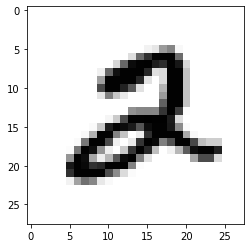

In [10]:
plot_digit(X_tc[5])

<Figure size 432x288 with 0 Axes>

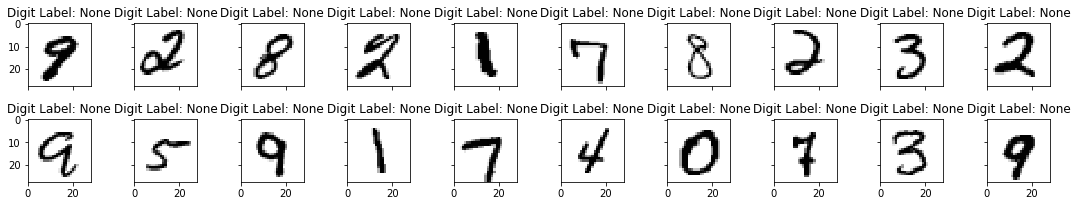

In [11]:
plot_n_random_digits(X_tc,n_images=20)

In [12]:
X_tc.shape

torch.Size([60000, 784])

In [28]:
mb_size = 250
Z_dim = 50
X_dim = X_tc.shape[1]
y_dim = y_tc.shape[1]
a_dim, b_dim, c_dim, h_dim = [784,392,196,98]
lr = 1e-3

torch_dataset = Data.TensorDataset(X_tc,y_tc)
loader = Data.DataLoader(
        dataset = torch_dataset,
        batch_size = mb_size,
        shuffle=True,
        pin_memory=True,
        num_workers=12
        )

In [32]:
class Encoder(torch.nn.Module):
    def __init__(self,ngpu):
        super(Encoder,self).__init__()
        self.ngpu = ngpu
        self.hidden1 = torch.nn.Linear(X_dim, a_dim)
        self.hidden2 = torch.nn.Linear(a_dim, b_dim)
        self.hidden3 = torch.nn.Linear(b_dim, c_dim)
        self.hidden4 = torch.nn.Linear(c_dim, h_dim)
        self.hidden5 = torch.nn.Linear(h_dim, Z_dim)
    
    def forward(self,X):
        h = F.relu(self.hidden1(X))
        h = F.relu(self.hidden2(h))
        h = F.relu(self.hidden3(h))
        h = F.relu(self.hidden4(h))
        mu = self.hidden5(h)
        log_var = self.hidden5(h)
        return mu, log_var

def sample_z(mu, log_sigma,mb_size):
    z = Variable(torch.randn(mb_size, Z_dim)).to(device)
    return (mu + torch.exp(log_sigma / 2) * z).to(device)

class Decoder(torch.nn.Module):
    def __init__(self,ngpu):
        super(Decoder,self).__init__()
        self.ngpu = ngpu
        self.hidden1 = torch.nn.Linear(Z_dim, h_dim)
        self.hidden2 = torch.nn.Linear(h_dim, c_dim)
        self.hidden3 = torch.nn.Linear(c_dim, b_dim)
        self.hidden4 = torch.nn.Linear(b_dim, a_dim)
        self.hidden5 = torch.nn.Linear(a_dim, X_dim)
    
    def forward(self,z):
        h = F.relu(self.hidden1(z))
        h = F.relu(self.hidden2(h))
        h = F.relu(self.hidden3(h))
        h = F.relu(self.hidden4(h))
        out = torch.sigmoid(self.hidden5(h))
        return out
    
encoder = Encoder(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    encoder = nn.DataParallel(encoder, list(range(ngpu)))
decoder = Decoder(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    decoder = nn.DataParallel(decoder, list(range(ngpu)))

params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=lr, betas=(0.9,0.999))
# decoder_optim = optim.Adam(decoder.parameters(), lr=lr, betas=(0.9,0.999))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight).to(device)
        m.bias.data.fill_(0.001)

#Inicializar pesos das redes
encoder.apply(init_weights)
decoder.apply(init_weights)

# lists to plot loss history
loss_his = []

In [30]:
#load saved networks
# encoder.load_state_dict(torch.load('models/encoder_mnist.pt'))
# decoder.load_state_dict(torch.load('models/decoder_mnist.pt'))

# print(encoder)
# print(decoder)

In [33]:
%%time
epochs = 30

for epoch in range(1,epochs+1):

    for step, batch_x in enumerate(loader):
        # Amostragem de dados
        X = Variable(batch_x[0]).to(device)
        X_size = X.shape[0]
        X = X.reshape(X_size,28*28).to(device)
        y = Variable(batch_x[0]).to(device)
        
        z_mu, z_var = encoder(X)
        z = sample_z(z_mu, z_var,X_size)
        X_sample = decoder(z)
        
        # Loss
        recon_loss = F.binary_cross_entropy(X_sample, X, reduction='sum')
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        loss = kl_loss + recon_loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Recolher dados das funções de perda
        loss_his.append(loss.data)

    # Mostrar dados ao longo das epochs
    if epoch % 10 == 0:
        print('Epoch-{}| Average loss: {:.5f}'.format(epoch, loss.mean().data))

Epoch-10| Average loss: 17871.47852
Epoch-20| Average loss: 17085.85156
Epoch-30| Average loss: 15628.43359
CPU times: user 36.3 s, sys: 9.56 s, total: 45.9 s
Wall time: 39.9 s


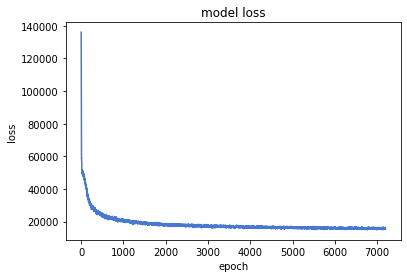

In [34]:
plt.plot(loss_his)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show();

In [18]:
# Save model
# torch.save(encoder.state_dict(), 'models/encoder_mnist.pt')
# torch.save(decoder.state_dict(), 'models/decoder_mnist.pt')

In [35]:
X_fake = generate_samples(encoder,decoder,mb_size=20)

<Figure size 432x288 with 0 Axes>

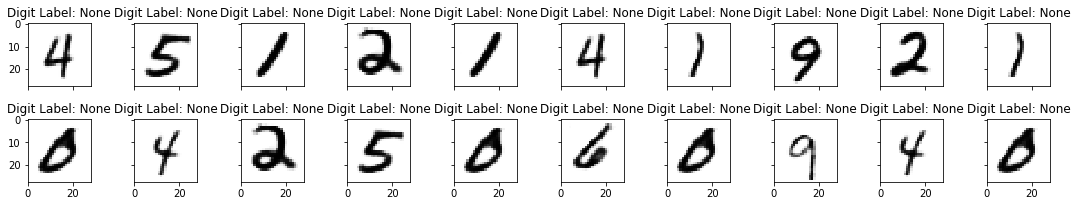

In [36]:
plot_n_random_digits(X_fake.cpu(),labels=None,n_images=20,title='Digits')

<Figure size 432x288 with 0 Axes>

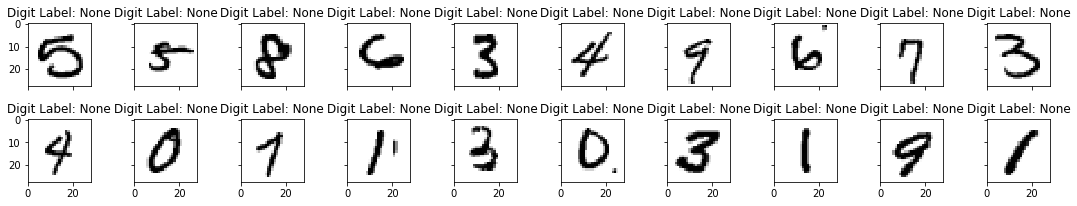

In [37]:
plot_n_random_digits(X_tc,n_images=20)

In [28]:
df = pd.DataFrame(data=X_tc[:1000].data.numpy(),columns=None)
df['target'] = labels[:1000]
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,target
290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [66]:
def generate_full_sample():
    X_samples = torch.Tensor().to(device)
    Z_samples = torch.Tensor().to(device)
    y_samples = torch.Tensor().to(device)
    for step, batch in enumerate(loader):
        X = Variable(batch[0]).to(device)
        y = Variable(batch[1]).to(device)
        z_mu, z_var = encoder(X)
        z = sample_z(z_mu, z_var,X.shape[0])
        X_samples = torch.cat([X_samples,decoder(z)],dim=0)
        Z_samples = torch.cat([Z_samples,z],dim=0)
        y_samples = torch.cat([y_samples,y],dim=0)
    return X_samples,Z_samples,torch.argmax(y_samples,dim=1)

In [67]:
X_samples,Z_samples,y_samples = generate_full_sample()
X_samples.shape,Z_samples.shape,y_samples.shape

(torch.Size([60000, 784]), torch.Size([60000, 50]), torch.Size([60000]))

In [68]:
y_samples

tensor([4, 4, 9,  ..., 3, 3, 0], device='cuda:0')

In [69]:
sample_size = 1000
X_fake = X_samples[:sample_size].cpu().data.numpy()
X_real = X_tc[:sample_size].cpu().data.numpy()
Z = Z_samples[:sample_size].cpu().data.numpy()
y_labels = y_samples[:sample_size].cpu().data.numpy()

## Visualizando o "espaço de features"

In [25]:
import umap

In [70]:
%%time
embedding_real = umap.UMAP(n_neighbors=25,min_dist=0.3,n_epochs=2000,
                      metric='euclidean').fit_transform(X_real)
embedding_fake = umap.UMAP(n_neighbors=25,min_dist=0.3,n_epochs=2000,
                      metric='euclidean').fit_transform(X_fake)

CPU times: user 20.9 s, sys: 3.16 s, total: 24 s
Wall time: 18.4 s


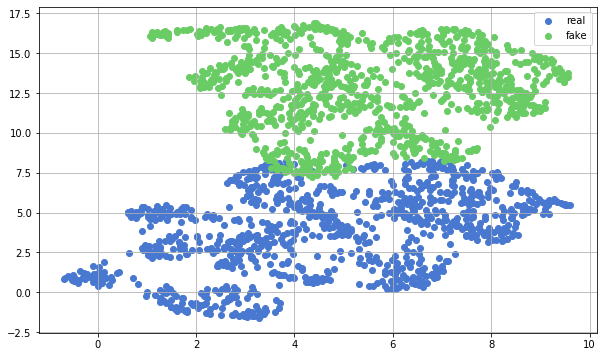

In [51]:
plt.figure(figsize=(10,6))
plt.scatter(x=embedding_real[:,0],y=embedding_real[:,1],label="real")
plt.scatter(x=embedding_fake[:,0],y=embedding_fake[:,1],label="fake")
plt.legend(loc=0)
plt.grid(True)
plt.show()

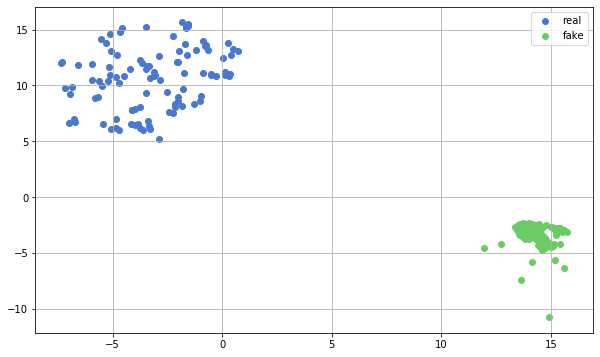

In [71]:
digit = 0
plt.figure(figsize=(10,6))
embedding_real_ = embedding_real[np.where(y_labels[:sample_size]==digit)]
embedding_fake_ = embedding_fake[np.where(y_labels[:sample_size]==digit)]
labels_ = [np.where(y_labels[:sample_size]==0)]
plt.scatter(x=embedding_real_[:,0],y=embedding_real_[:,1],label="real")
plt.scatter(x=embedding_fake_[:,0],y=embedding_fake_[:,1],label="fake")
plt.legend(loc=0)
plt.grid(True)
plt.show()

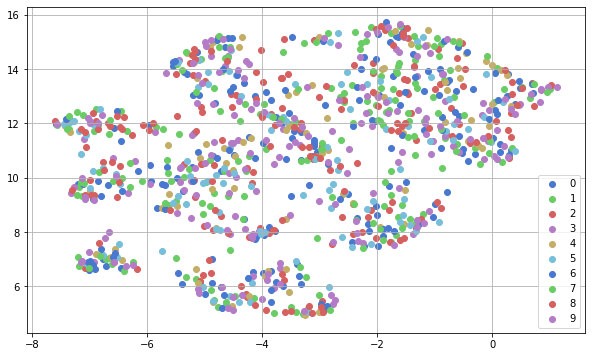

In [72]:
plt.figure(figsize=(10,6))
for i in range(10):
    embedding_real_ = embedding_real[np.where(y_labels[:sample_size]==i)]
    labels_ = [np.where(y_labels[:sample_size]==0)]
    plt.scatter(x=embedding_real_[:,0],y=embedding_real_[:,1],label=i)
plt.legend(loc=0)
plt.grid(True)
plt.show()

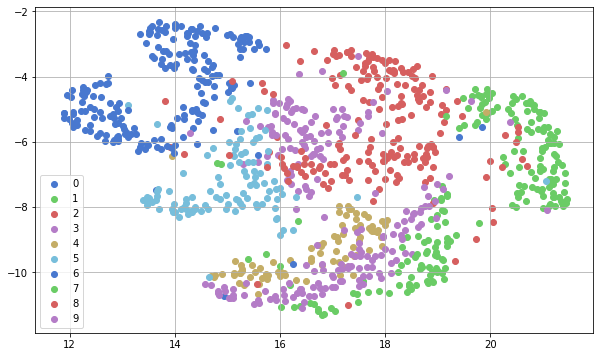

In [76]:
plt.figure(figsize=(10,6))
for i in range(10):
    embedding_fake_ = embedding_fake[np.where(y_labels[:sample_size]==i)]
    labels_ = [np.where(y_labels[:sample_size]==0)]
    plt.scatter(x=embedding_fake_[:,0],y=embedding_fake_[:,1],label=i)
plt.legend(loc=0)
plt.grid(True)
plt.show()

## Visualizando o "espaço latente"

In [77]:
%%time
embedding_Z = umap.UMAP(n_neighbors=50,min_dist=0.5,n_epochs=2000,
                      metric='euclidean').fit_transform(Z)

CPU times: user 12.6 s, sys: 1.44 s, total: 14.1 s
Wall time: 11.5 s


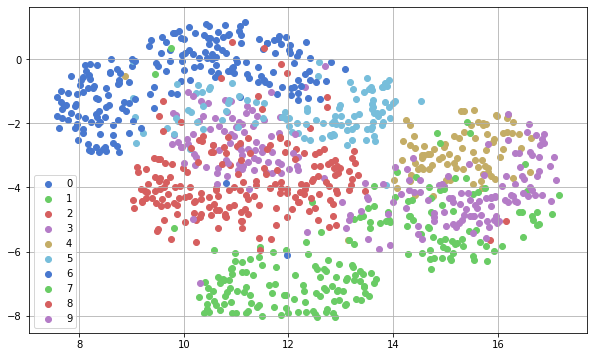

In [78]:
plt.figure(figsize=(10,6))
for i in range(10):
    embedding_Z_ = embedding_Z[np.where(y_labels[:sample_size]==i)]
    labels_ = [np.where(y_labels[:sample_size]==0)]
    plt.scatter(x=embedding_Z_[:,0],y=embedding_Z_[:,1],label=i)
plt.legend(loc=0)
plt.grid(True)
plt.show()